Here, we'll try to evaluate our model in a betting simulation!

In [1]:
from tennis_new.fetch.tennis_explorer.combiner import read_joined

jd = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv_377/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [2]:
from tennis_new.model.config.elo.global_set_elo import SetELO

set_elo = SetELO()
set_elo.run(jd)
set_elo.validation_evaluation

{'DummyFilter_prediction_AUCMetric': 0.8187031847302881,
 'DummyFilter_prediction_AccuracyMetric': 0.7358520800135314,
 'DummyFilter_prediction_LogLikelihoodMetric': -0.5226366377611569,
 'HasOddsFilter_prediction_AUCMetric': 0.7839029874196454,
 'HasOddsFilter_prediction_AccuracyMetric': 0.7056423354253945,
 'HasOddsFilter_prediction_LogLikelihoodMetric': -0.5594758958654537,
 'DummyFilter_odds_implied_probability_AUCMetric': None,
 'DummyFilter_odds_implied_probability_AccuracyMetric': None,
 'DummyFilter_odds_implied_probability_LogLikelihoodMetric': None,
 'HasOddsFilter_odds_implied_probability_AUCMetric': 0.7937506478103871,
 'HasOddsFilter_odds_implied_probability_AccuracyMetric': 0.7114980299325661,
 'HasOddsFilter_odds_implied_probability_LogLikelihoodMetric': -0.5501844612492598}

In [237]:
from tennis_new.model.utils.filters import HasOddsFilter

validation_data = set_elo.test_filter.filter_data(set_elo.all_jd)
val_has_odds = HasOddsFilter().filter_data(validation_data)
val_has_odds['casino_margin'] = (1. / val_has_odds['p1_odds'] + 1. / val_has_odds['p2_odds'])

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv_377/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [241]:
my_data = val_has_odds[val_has_odds['casino_margin'] > 1.03].copy()

#### Betting Strategy 1: Directional Betting

Here, we place a bet whenever the odds imply a <50% chance of winning for the player we think is the favorite.  This strategy requires no calibration, so we expect it to be OK to start.

In [242]:
BUFFER = 0.  # What margin do we want over the house before we place a bet?

my_data['bet_p1'] = (
    (my_data['p1_odds'] > 2.) &
    (my_data['prediction'] > (0.5 + BUFFER))
)
my_data['bet_p2'] = (
    (my_data['p2_odds'] > 2.) &
    (my_data['prediction'] < (0.5 - BUFFER))
)

In [243]:
my_data['bet_p1'].sum()

5490

In [244]:
my_data['bet_p2'].sum()

7249

In [245]:
profit = (my_data['bet_p1'] * my_data['p1_odds']).sum() - my_data['bet_p1'].sum() - my_data['bet_p2'].sum()
profit

535.8799999999992

In [246]:
profit / (my_data['bet_p1'].sum() + my_data['bet_p2'].sum()) 

0.04206609623989318

Above, we're profiting!  Without any buffer, with a fairly rudimentary model, with no set adjustment, with no h2h history, and most importantly, without reducing the crazy margins of the house.  This is great!  Let's see how likely we are to make this much if we chose this many random bets.

#### Profit Distribution from Random Betting

Below, we bet on a random sample of matches of the same size as above to see whether our returns are stastistically significantly good...

100%|██████████| 1000/1000 [00:19<00:00, 50.49it/s]


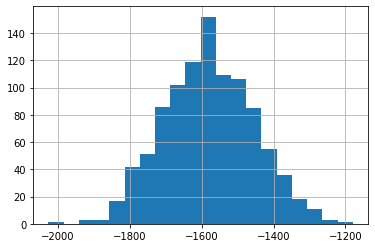

In [247]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm

N_ITERS = 1000


n_bets = my_data['bet_p1'].sum() + my_data['bet_p2'].sum()
profits = []

for _ in tqdm(range(N_ITERS)):
    sample_matches = my_data.sample(n_bets, replace=False)
    p1_bets = (np.random.uniform(size=n_bets) < 0.5)
    p2_bets = 1. - p1_bets
    profit = (sample_matches['p1_odds'] * p1_bets).sum() - n_bets
    profits.append(profit)

pd.Series(profits).hist(bins=20)

We're doing wayyy better than random...

In [248]:
pd.Series(profits).mean() / n_bets

-0.12401877148912786

In [249]:
(1. / my_data['p1_odds'] + 1. / my_data['p2_odds']).mean()

1.0826488631667617

#### Fix Odds to Match Real Margins

One issue we have above is that the odds I've scraped present unrealistically large margins for the casino (roughly 8%).  Now, we plot our profit as a function of 'adjusted' margins.  We adjust our margins by multiplying our odds by a constant factor. 

In [250]:
def get_adjusted_odds(desired_margin, old_p1_odds, old_p2_odds):
    multiplier = 1. / (desired_margin * old_p1_odds) + 1. / (desired_margin * old_p2_odds)
    return multiplier * old_p1_odds, multiplier * old_p2_odds

def evaluate_against_odds(p1_odds, p2_odds, prediction):
    bet_p1 = (p1_odds > 2.) & (prediction > 0.5)
    bet_p2 = (p2_odds > 2.) & (prediction < 0.5)
    n_bets = bet_p1.sum() + bet_p2.sum()
    profit = (p1_odds * bet_p1).sum() - n_bets 
    ret = profit / n_bets
    return profit, ret

margins = np.linspace(1.0, 1.1, 20)
profits = []
rets = []
for desired_margin in tqdm(margins):
    p1, p2 = get_adjusted_odds(desired_margin, my_data['p1_odds'], my_data['p2_odds'])
    profit, ret = evaluate_against_odds(p1, p2, my_data['prediction'])
    profits.append(profit)
    rets.append(ret)

100%|██████████| 20/20 [00:00<00:00, 107.23it/s]


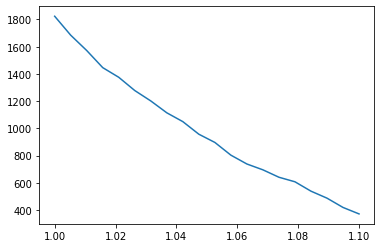

In [251]:
from matplotlib import pyplot as plt

plt.plot(margins, profits)

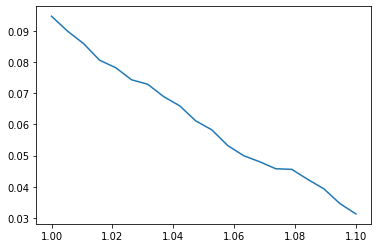

In [252]:
plt.plot(margins, rets)

Sweet, we're doing pretty well, and with a model with many known flaws!  Let's now try to evaluate using a more sophisticated strategy -- comparing our probabilities to those implied by the odds.  This strategy relies on model calibration, so let's take a look at that...

#### Calibration Evaluation

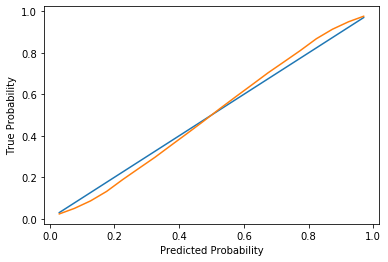

In [253]:
from sklearn.calibration import calibration_curve

def get_calibration_plot(df, prediction_col='prediction'):
    preds = np.concatenate([
        df[prediction_col].values,
        1. - df[prediction_col].values
    ])
    truth = np.concatenate([
        np.ones(df.shape[0]),
        np.zeros(df.shape[0])
    ])
    _y, _x = calibration_curve(truth, preds, n_bins=20)
    plt.plot(_x, _x)
    plt.plot(_x, _y)
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    return _x, _y

pred_b, truth_b = get_calibration_plot(my_data)

Above, we see our predictions are generally not extreme enough.  This is not surprising, given that our model:

(1) Was not fit with a likelihood loss (although it was inspired by a likelihood model)
(2) Is fit on set wins, rather than match wins.

We'll take an initial look at the second hypothesis by looking at calibration separately by best-of-3-set matches and best-of-5-set matches. We expect our degree of miscalibration to be greater for 5 set matches than 3 set matches.

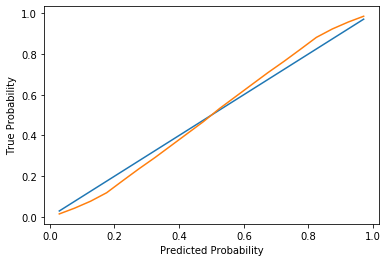

In [254]:
_ = get_calibration_plot(my_data[my_data['p1_sets_won'] == 2])

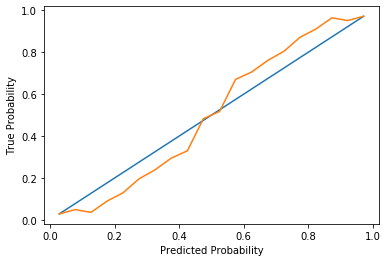

In [255]:
_ = get_calibration_plot(my_data[my_data['p1_sets_won'] == 3])

Above, we see that indeed our under calibration was greater for 5 set matches than it was for 3 set matches.  We also note that in both cases, the miscalibration is fairly S-shaped.  This means a basic Platt correction (running the model output through a sigmoid) might suffice for recalibration, rather than using a more sophisticated calibrator.  However, we'll start with the most obvious thing: Use analytical math to convert the set probabilities into match probabilities.

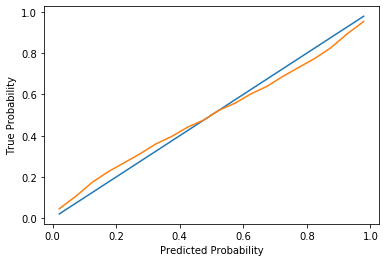

In [256]:
def get_3_set_prediction(p):
    return (
        p * p +
        (1 - p) * p * p + 
        p * (1 - p) * p
    )

def get_5_set_prediction(p):
    return (
        p ** 3 + 
        3 * (p ** 3) * (1 - p) + 
        6 * (p ** 3) * ((1 - p) ** 2)
    )

my_data['3_set_prob'] = my_data['prediction'].map(get_3_set_prediction)
my_data['5_set_prob'] = my_data['prediction'].map(get_5_set_prediction)
_ = get_calibration_plot(my_data[my_data['p1_sets_won'] == 2], prediction_col='3_set_prob')

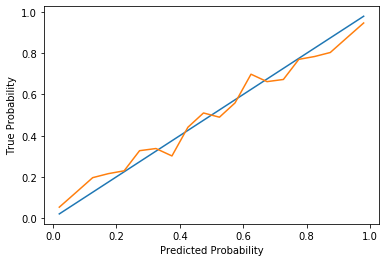

In [257]:
_ = get_calibration_plot(my_data[my_data['p1_sets_won'] == 3], prediction_col='5_set_prob')

Interestingly, our predictions are now not extreme enough (at least for the 3 set case)!  Perhaps players make in-game adjustments so sets are not actually i.i.d within a match?  Or perhaps it just has to do with ELO not being a likelihood model in the first place?  Or perhaps most matches occur closer to true 0.5 and the scale of the sigmoid doesn't quite make sense for more extreme differences?

#### Try Betting with Calibrated Probabilities

Now, let's try calibrating our probabilities.  Note that for now we'll cheat a little bit and fit the calibrator on the same dataset on which we're betting.  In the future, we'll attempt fitting the calibrator in a time split.

##### Calibration Methodology 1: Platt Scaling 

First, we'll try "Platt Scaling" our probabilities to get something calibrated.

In [258]:
from sklearn.linear_model import LogisticRegression

def log_odds(x):
    return np.log(x / (1. - x))


logit = LogisticRegression(fit_intercept=False)
my_data['is_5_setter'] = ((my_data['p1_sets_won'] == 3).astype(int) * my_data['prediction'])
my_data['log_odds_prediction'] = log_odds(my_data['prediction'])
mdc = my_data.copy()
mdc['log_odds_prediction'] = log_odds(1. - mdc['prediction'])
_X = pd.concat([
    my_data[['log_odds_prediction', 'is_5_setter']],
    mdc[['log_odds_prediction', 'is_5_setter']]
])
_y = np.concatenate([
    np.ones(my_data.shape[0]),
    np.zeros(my_data.shape[0])
])
logit.fit(_X, _y)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv_377/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

(array([0.02680195, 0.07590737, 0.12540846, 0.17557623, 0.22563519,
        0.27519639, 0.32535495, 0.37518734, 0.4252137 , 0.47478184,
        0.5252332 , 0.5747863 , 0.62481266, 0.67464505, 0.72480361,
        0.77436481, 0.82442377, 0.87459154, 0.92409263, 0.97319805]),
 array([0.03152185, 0.07398863, 0.11409972, 0.17990891, 0.22764604,
        0.27444415, 0.325957  , 0.37691009, 0.4288    , 0.47270482,
        0.52731146, 0.5712    , 0.62308991, 0.674043  , 0.72555585,
        0.77235396, 0.82009109, 0.88590028, 0.92601137, 0.96847815]))

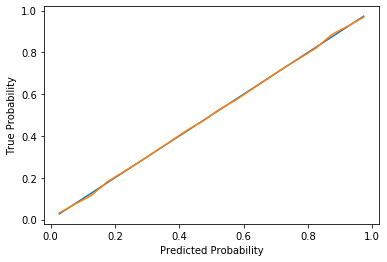

In [259]:
my_data['platt_pred'] = logit.predict_proba(my_data[['log_odds_prediction', 'is_5_setter']])[:, 1]
get_calibration_plot(my_data, 'platt_pred')

In [260]:
logit.coef_

array([[1.19017983e+00, 1.03487185e-16]])

So, it seems like on the training set, that Platt scaling works very well here!  It looks like we use a scaling factor of 1.19, and that we do not need to adjust the scaling factor further for 5 setters (or that there isn't very much data on best-of-5 matches).  Now let's see what happens if we try to bet with such predictions.  Our betting strategy will be to bet if the predicted probability exceeds the odds-implied probability by at least BUFFER points.  We will iterate over values of BUFFER to start.

In [261]:
buffers = np.linspace(0, 0.3, 51)
profits = []
returns = []
bet_counts = []

for buffer in tqdm(buffers):
    bet_p1 = my_data['platt_pred'] > (1. / my_data['p1_odds'] + buffer)
    bet_p2 = (1. - my_data['platt_pred']) > (1. / my_data['p2_odds'] + buffer)
    n_bets = bet_p1.sum() + bet_p2.sum()
    profit = (bet_p1 * my_data['p1_odds']).sum() - n_bets
    ret = profit / n_bets
    profits.append(profit)
    returns.append(ret)
    bet_counts.append(n_bets / my_data.shape[0])

100%|██████████| 51/51 [00:00<00:00, 113.14it/s]


Text(0, 0.5, 'profit')

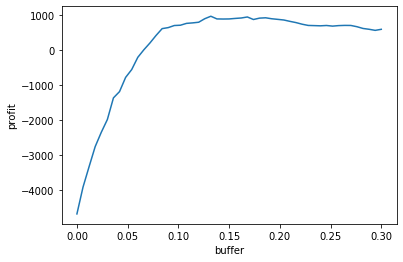

In [262]:
plt.plot(buffers, profits)
plt.xlabel("buffer")
plt.ylabel("profit")

Text(0, 0.5, 'return')

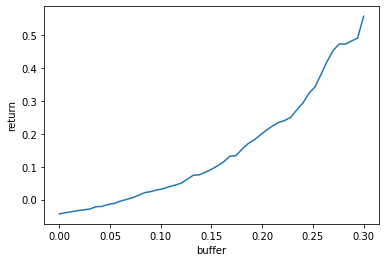

In [263]:
plt.plot(buffers, returns)
plt.xlabel("buffer")
plt.ylabel("return")

Text(0, 0.5, 'return')

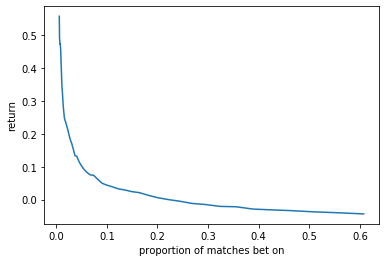

In [269]:
plt.plot(bet_counts, returns)
plt.xlabel("proportion of matches bet on")
plt.ylabel("return")

Above, we see that we can achieve a very good return if we bet on a relatively small percentage of matches that have large margins.  Once weadjust our odds to be more reasonable, we will likely be even to do even better!

In [266]:
# With a large margin, are we necessarily betting on matches with very low casino margins? 
buffer = 0.1
bet_p1 = my_data['platt_pred'] > (1. / my_data['p1_odds'] + buffer)
bet_p2 = (1. - my_data['platt_pred']) > (1. / my_data['p2_odds'] + buffer)
w_bet = my_data[
    bet_p1 | bet_p2
]
w_bet['casino_margin'].describe()

count    22394.000000
mean         1.082177
std          0.013466
min          1.030667
25%          1.073320
50%          1.083179
75%          1.091822
max          1.128995
Name: casino_margin, dtype: float64

So far, it looks like we're off to a really good start in terms of making money!  We're already profitable and we aren't even using a very sophisticated algorithm yet!  Finally, let's bootstrap our betting results to see what kind of distribution we have over our returns.

In [281]:
# With a large margin, are we necessarily betting on matches with very low casino margins? 
buffer = 0.1
bet_p1 = my_data['platt_pred'] > (1. / my_data['p1_odds'] + buffer)
bet_p2 = (1. - my_data['platt_pred']) > (1. / my_data['p2_odds'] + buffer)
w_bet = my_data[
    bet_p1 | bet_p2
]

to_bootstrap = pd.DataFrame({
    'odds': my_data['p1_odds'].values,
    'bet_p1': bet_p1,
    'bet_p2': bet_p2
})
to_bootstrap = to_bootstrap[to_bootstrap['bet_p1'] | to_bootstrap['bet_p2']]  # Keep only rows with a bet

N_ITERS = 1000
profits = []
for _ in tqdm(range(N_ITERS)):
    cur_samp = to_bootstrap.sample(to_bootstrap.shape[0], replace=True)
    profit = (cur_samp['bet_p1'] * cur_samp['odds']).sum() - (cur_samp['bet_p1'].sum() + cur_samp['bet_p2'].sum())
    profits.append(profit)

100%|██████████| 1000/1000 [00:02<00:00, 406.33it/s]


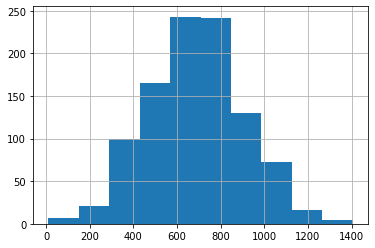

In [282]:
pd.Series(profits).hist()

In [285]:
pd.Series(profits).describe(percentiles=np.linspace(0, 1, 11))

count    1000.000000
mean      686.837000
std       219.164654
min        10.350000
0%         10.350000
10%       392.389000
20%       500.424000
30.0%     573.604000
40%       632.986000
50%       685.605000
60.0%     743.014000
70%       801.629000
80%       862.330000
90%       977.949000
100%     1405.430000
max      1405.430000
dtype: float64

Above, we see that our returns are fairly stable -- very unlikely to lose money with this strategy.